This notebook performs some analysis of a randomly selected set of sequences for autoencoder training
(half decoy, half "true" antibody) using three different models: Anarci, BioPhi and AbLSTM.
This is not a key experiment and is not necessary for the pipeline but was useful for
understanding some properties of the autoencoder trained on unlabelled antibody data.

The Anarci "human-ness" score is already included since these sequences were all numbered originally
using Chothia. In order to run this notebook, you will need to have AbLSTM in the same working
directory as this notebook. AbLSTM is available on github at: https://github.com/lzd0825/AB-LSTM .
In this notebook, it is assumed that AbLSTM has been cloned into "peds2019" in the
same working directory as this notebook.

The sampled sequences are included in the same working directory with this notebook
in .fasta format; BioPhi can use the fasta files as input for scoring. The BioPhi
scores generated in this fashion have already been saved in this directory as
"orig_scores.csv" and "decoy_scores.csv". If you would like to re-score these
sequences, you can obtain and install BioPhi from https://github.com/Merck/BioPhi
and run it on these .fasta files.

The scoring for AbLSTM is performed in this notebook, using the .txt files.
The Anarci scores were generated when the sequences were processed and are 
included in this directory as .csv files.

In [1]:
import os
import pickle
import torch
import numpy as np

os.chdir("peds2019")
from ablstm import ModelLSTM
model = ModelLSTM(embedding_dim=64, hidden_dim=64, device='cuda', gapped=True, fixed_len=True)
os.chdir("..")

In [2]:
if "trained_lstm.pk" in os.listdir():
    with open("trained_lstm.pk", "rb") as fhandle:
        model = pickle.load(fhandle)

else:
    trn_fn = 'peds2019/data/sample/human_train.txt'
    vld_fn = 'peds2019/data/sample/human_val.txt'
    model.fit(trn_fn=trn_fn, vld_fn=vld_fn, n_epoch=10, trn_batch_size=128, vld_batch_size=512, lr=.002, save_fp=None)
    with open("trained_lstm.pk", "wb") as fhandle:
        pickle.dump(model, fhandle)

In [3]:
with open("sampled_harvested_autoencoder_seqs.pk", "rb") as fhandle:
    seqs = pickle.load(fhandle)
    seqs = [s.replace("-", "") for s in seqs]
seqs = seqs[:int(0.2 * len(seqs))]
labels = torch.load("sampled_harvested_autoencoder_labels.pt").numpy()
labels = labels[:int(0.2 * labels.shape[0])].tolist()

with open("sampled_harvested_original_seqs.fasta", "w+") as fhandle1:
    with open("sampled_harvest_decoy_seqs.fasta", "w+") as fhandle2:
        for i, seq in enumerate(seqs):
            if labels[i] == 0:
                fhandle1.write(f">{i}\n")
                fhandle1.write(seq)
                fhandle1.write("\n")
            else:
                fhandle2.write(f">d{i}\n")
                fhandle2.write(seq)
                fhandle2.write("\n")

  0%|| 0/23758 [00:00<?, ?seq/s]/home/jlparkinson1/Documents/PDL1/venv_pdl1/lib/python3.6/site-packages/torch/nn/modules/rnn.py:662: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
100%|| 24014/24014 [00:02<00:00, 9451.22seq/s]


MannwhitneyuResult(statistic=3872.0, pvalue=0.0)

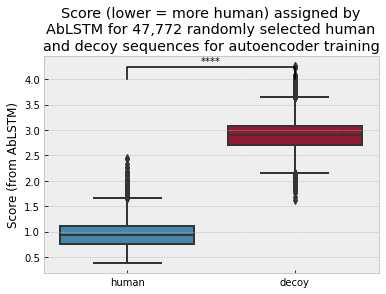

In [5]:
orig_scores = model.eval(fn="orig.txt", batch_size=512)
decoy_scores = model.eval(fn="decoys.txt", batch_size=512)

text_labs = ["human" for i in range(orig_scores.shape[0])] + ["decoy" for i in range(decoy_scores.shape[0])]
scores = np.concatenate([orig_scores, decoy_scores])

with open("human-ness_scores.csv", "w+") as fhandle:
    fhandle.write("Sequence_category,model,score\n")
    for text_lab, score in zip(text_labs, scores.tolist()):
        fhandle.write(f"{text_lab},AB-LSTM,{score}\n")



import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu as MWU

plt.style.use("bmh")
sns.boxplot(x=text_labs, y=scores)
ylow, yhigh = 4, 4.25
plt.plot([0,0,1,1], [ylow,yhigh,yhigh,ylow], lw=1.5, color="black")
plt.text(0.5, yhigh, "****", ha="center", va="bottom", c="black")
plt.title("Score (lower = more human) assigned by\nAbLSTM for 47,772 randomly selected human\n"
          "and decoy sequences for autoencoder training")
plt.ylabel("Score (from AbLSTM)")
plt.savefig("AbLSTM_scores.eps", format="eps")

MWU(orig_scores.astype(np.float64), decoy_scores.astype(np.float64))

In [6]:
import pandas as pd
orig_df = pd.read_csv("orig.csv")
decoy_df = pd.read_csv("decoys.csv")

scores = np.concatenate([orig_df.score.values, decoy_df.score.values])
text_labs = ["human" for i in range(orig_df.shape[0])] + ["decoy" for i in range(decoy_df.shape[0])]

with open("human-ness_scores.csv", "a") as fhandle:
    for text_lab, score in zip(text_labs, scores.tolist()):
        fhandle.write(f"{text_lab},ANARCI,{score}\n")

MannwhitneyuResult(statistic=156567096.5, pvalue=0.0)


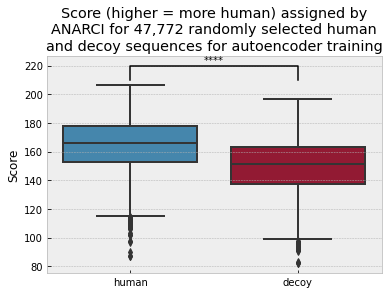

In [7]:
plt.title("Score (higher = more human) assigned by\nANARCI for 47,772 randomly selected human\n"
          "and decoy sequences for autoencoder training")
sns.boxplot(x=text_labs, y=scores)
ylow, yhigh = 210, 220
plt.plot([0,0,1,1], [ylow,yhigh,yhigh,ylow], lw=1.5, color="black")
plt.text(0.5, yhigh, "****", ha="center", va="bottom", c="black")
plt.ylabel("Score")
plt.savefig("ANARCI_scores.eps", format="eps")

print(MWU(orig_df.score.values, decoy_df.score.values))

In [8]:
orig_df = pd.read_csv("orig_scores.csv")
decoy_df = pd.read_csv("decoy_scores.csv")

scores = np.concatenate([orig_df.sapiens_score.values, decoy_df.sapiens_score.values])
text_labs = ["human" for i in range(orig_df.shape[0])] + ["decoy" for i in range(decoy_df.shape[0])]

with open("human-ness_scores.csv", "a") as fhandle:
    for text_lab, score in zip(text_labs, scores.tolist()):
        fhandle.write(f"{text_lab},BioPhi,{score}\n")

MannwhitneyuResult(statistic=100245236.0, pvalue=0.0)


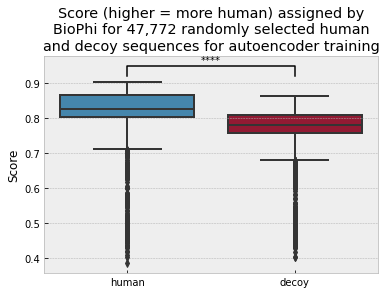

In [9]:
plt.title("Score (higher = more human) assigned by\nBioPhi for 47,772 randomly selected human\n"
          "and decoy sequences for autoencoder training")
sns.boxplot(x=text_labs, y=scores)
ylow, yhigh = 0.92, 0.95
plt.plot([0,0,1,1], [ylow,yhigh,yhigh,ylow], lw=1.5, color="black")
plt.text(0.5, yhigh, "****", ha="center", va="bottom", c="black")
plt.ylabel("Score")
plt.savefig("BioPhi_scores.eps", format="eps")

print(MWU(orig_df.sapiens_score.values, decoy_df.sapiens_score.values))